# FCPG Test Notebook

This notebook facilitates testing the the core functionality of the FCPG tools. This steps through providing input data, converting ESRI flow directions to TauDEM flow direction, resampling and reprojecting input data, generating upstream FCPGs, creating a dictionary to cascade values from upstream to downstream hydrologic units, updating downstream parameter grids, accumulating updated grids, and making FCPGs corrected for an upstream area. The last section verifies the handling of no data values if that is desired by the user.

This notebook reads data from `./test_data` and writes data to `./test_output`. `./test_output` can be discarded after testing is complete.

Input and output grids can be examined in either ArcGIS or QGIS.

In [40]:
import FCPGtools as fc
import os
import rasterio as rs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

def plot(fl, cmap='Blues'): # define a helper plotting function
    src = rs.open(fl)
    tmp = src.read(1)
    tmp[tmp == src.nodata] = np.NaN
    plt.figure(figsize = (10,10))
    plt.imshow(tmp, cmap = cmap)

In [2]:
# input data sets
upstreamFDR = os.path.join('.','test_data','validation_upstream_fdr.tif') # upstream area FDR grid
downstreamFDR = os.path.join('.','test_data','validation_downstream_fdr.tif') # downstream area FDR grid
upstreamWBD = gpd.read_file(os.path.join('.','test_data/upstream_wbd.shp')) # upstream WBD subset to test cascading parameters


# parameter datasets
P = os.path.join('.','test_data','validation_daymet_an_P_2017.tif') # daymet annual P for 2017
LC = os.path.join('.','test_data','NALCMS_2015.tif') # North America Land Cover 2015

testFolder = os.path.join('.','test_output') # folder to store outputs

In [3]:
# reproject the WBD to the grid CRS
tmp = rs.open(upstreamFDR)
dstCRS = tmp.crs.to_proj4()

upstreamWBD.to_crs(crs=dstCRS, inplace=True)

In [4]:
if os.path.exists(testFolder) == False: # make test output location if it doesn't exist, this directory can be deleted later
    os.mkdir(testFolder)

## Convert ESRI FDR to TauDEM FDR

In [5]:
# define output paths
upstreamFDRTau = os.path.join(testFolder,'upstreamFDRtau.tif')
downstreamFDRTau = os.path.join(testFolder,'downstreamFDRtau.tif')

In [6]:
# reclassify ESRI drainage directions to TauDEM
fc.tauDrainDir(upstreamFDR, upstreamFDRTau)
fc.tauDrainDir(downstreamFDR, downstreamFDRTau)

Reclassifying Flow Directions...
TauDEM drainage direction written to: ./test_output/upstreamFDRtau.tif
Reclassifying Flow Directions...
TauDEM drainage direction written to: ./test_output/downstreamFDRtau.tif


## Resample Daymet and Land Cover

In [7]:
# define output paths
Pupstream = os.path.join(testFolder,'Pup.tif')
Pdownstream = os.path.join(testFolder,'Pdwn.tif')
LCupstream = os.path.join(testFolder,'LCup.tif')
LCdownstream = os.path.join(testFolder,'LCdwn.tif')

In [8]:
fc.resampleParam(P,upstreamFDRTau, Pupstream) # resample and crop daymet upstream
fc.resampleParam(P,downstreamFDRTau,Pdownstream) # downstream
fc.resampleParam(LC, downstreamFDRTau, LCdownstream)
fc.resampleParam(LC, upstreamFDRTau, LCupstream)

Flow Direction Proj4: PROJCS["NAD_1983_Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Parameter Proj4:PROJCS["Lambert_Conformal_Conic_2SP",GEOGCS["GCS_unknown",DATUM["D_unknown",SPHEROID["Spheroid",6378137,298.25723]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",60],PARAMETER["latitude_of_origin",42.5],PARAMETER["central_meridian",-100],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNI

## Binarize Land Cover

In [9]:
usLCbinary = fc.cat2bin(LCupstream, testFolder)
dsLCbinary = fc.cat2bin(LCdownstream, testFolder)

Creating binaries for ./test_output/LCup.tif
Saving ./test_output/LCup0.tif
Saving ./test_output/LCup1.tif
Saving ./test_output/LCup2.tif
Saving ./test_output/LCup3.tif
Saving ./test_output/LCup4.tif
Saving ./test_output/LCup5.tif
Saving ./test_output/LCup6.tif
Saving ./test_output/LCup7.tif
Saving ./test_output/LCup8.tif
Saving ./test_output/LCup9.tif
Saving ./test_output/LCup10.tif
Saving ./test_output/LCup11.tif
Saving ./test_output/LCup12.tif
Saving ./test_output/LCup13.tif
Saving ./test_output/LCup14.tif
Saving ./test_output/LCup15.tif
Saving ./test_output/LCup16.tif
Saving ./test_output/LCup17.tif
Saving ./test_output/LCup18.tif
Creating binaries for ./test_output/LCdwn.tif
Saving ./test_output/LCdwn1.tif
Saving ./test_output/LCdwn2.tif
Saving ./test_output/LCdwn0.tif
Saving ./test_output/LCdwn3.tif
Saving ./test_output/LCdwn4.tif
Saving ./test_output/LCdwn5.tif
Saving ./test_output/LCdwn6.tif
Saving ./test_output/LCdwn7.tif
Saving ./test_output/LCdwn8.tif
Saving ./test_output/LC

## Accumulate the Upstream Area

In [10]:
upstreamFAC = os.path.join(testFolder,'upstreamFAC.tif') # path for the output FAC grid.

fc.tauFlowAccum(upstreamFDRTau,upstreamFAC, cores=4)

Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/upstreamFAC.tif -nc


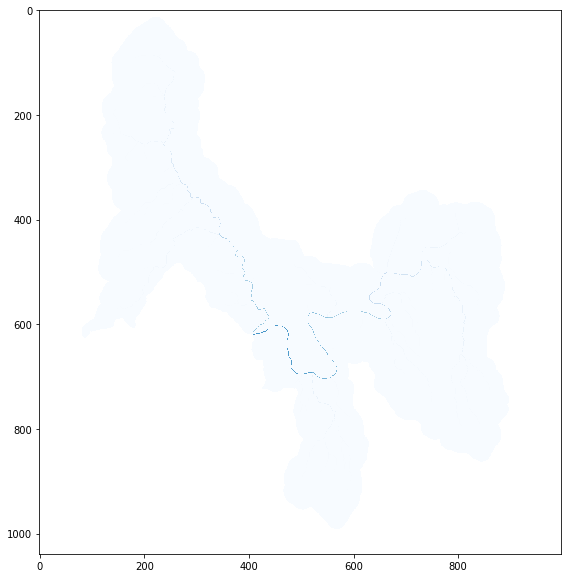

In [41]:
plot(upstreamFAC)

## Demonstration of Multiple Pour Points

The following is a demonstration of the workflow for HUC4 geospatial tiles (NHD High-Res). The update dictionary produced here is not used after this Section.

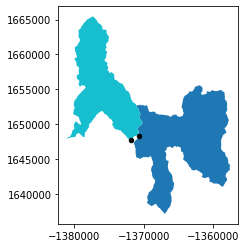

In [12]:
pourBasins = fc.makePourBasins(upstreamWBD,'1407','1501')
pourPts = fc.findPourPoints(pourBasins,upstreamFAC, upstreamFDRTau, plotBasins=True)

In [13]:
pourBasins

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,NonContrib,NonContr_1,AreaSqKm,...,States,HUC12,HUType,HUMod,ToHUC,Shape_Leng,Shape_Area,geometry,HUC4,ToHUC4
0,2685,{AAAE4745-7F69-4249-9EE6-61A0FDD375D2},{2E2678AC-0C9D-49CB-806B-540A9302D247},None,None,None,2013-01-18,0.0,0.0,133.04,...,AZ,140700061105,S,DM,150100010303,0.805006,0.013444,POLYGON ((-1357947.567609239 1651035.024641215...,1407,1501
1,2737,{6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB},{AEC557FF-82D8-4F4D-BF0D-2BF431714390},None,None,None,2017-10-25,0.0,0.0,90.55,...,"AZ,UT",140700070706,S,NM,150100010303,0.612730,0.009157,"POLYGON ((-1377191.80550942 1665386.802721771,...",1407,1501


In [14]:
pourPts

[(-1370699.9999999995, 1648259.9999999963, 155007.0),
 (-1371809.9999999995, 1647749.9999999963, 101615.0)]

In [15]:
# create an initial dictionary for the region 14 to 15 cascade
updateDictFl = os.path.join(testFolder,'HUC1407_update.json')
upHUC = '1407'
x,y,w = zip(*pourPts) # expand the pour points

ud = fc.createUpdateDict(x,y,w,upHUC, updateDictFl)

In [16]:
ud # there are two pour points

{'1407': {'x': ['-1370699.9999999995', '-1371809.9999999995'],
  'y': ['1648259.9999999963', '1647749.9999999963'],
  'maxUpstreamFAC': ['155007.0', '101615.0'],
  'vars': ['maxUpstreamFAC']}}

## Find Pour Point to Downstream Area

In [17]:
# find the single pour point between region 14 and region 15.
x,y,d,w = fc.findLastFACFD(upstreamFAC, fl = upstreamFAC) # locate max FAC value.
x,y,f,w = fc.findLastFACFD(upstreamFAC, fl = upstreamFDRTau) # Get flow direction of above point

In [18]:
# create an initial dictionary for the region 14 to 15 cascade
updateDictFl = os.path.join(testFolder,'HUC14_update.json')
upHUC = '14'
ud = fc.createUpdateDict([x],[y],[d],upHUC, updateDictFl)

## FCPG Upstream Daymet and Land Cover

In [19]:
usLCbinary.append(Pupstream) # append the Daymet path to the land cover binary grids

In [20]:
accumParams = fc.accumulateParams(usLCbinary,upstreamFDRTau,testFolder,cores = 4)

Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/LCup0accum.tif -wg ./test_output/LCup0.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/LCup1accum.tif -wg ./test_output/LCup1.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/LCup2accum.tif -wg ./test_output/LCup2.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/LCup3accum.tif -wg ./test_output/LCup3.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/LCup4accum.tif -wg ./test_output/LCup4.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/LCup5accum.tif -wg ./test_output/LCup5.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/LCup6accum.tif -wg ./test_output/LCup6.tif -nc

In [21]:
upstream_cpgs = fc.make_fcpgs(accumParams,upstreamFAC,testFolder)

Reading accumulated parameter file 2020-06-22 16:27:39.856519
Reading basin flow accumulation file 2020-06-22 16:27:39.878342
Computing CPG values 2020-06-22 16:27:39.887039
Replacing numpy nan values 2020-06-22 16:27:39.895278
Saving CPG raster 2020-06-22 16:27:39.896183
CPG file written to: ./test_output/LCup0accumFCPG.tif
Reading accumulated parameter file 2020-06-22 16:27:39.921371
Reading basin flow accumulation file 2020-06-22 16:27:39.941634
Computing CPG values 2020-06-22 16:27:39.950656
Replacing numpy nan values 2020-06-22 16:27:39.957782
Saving CPG raster 2020-06-22 16:27:39.958608
CPG file written to: ./test_output/LCup1accumFCPG.tif
Reading accumulated parameter file 2020-06-22 16:27:39.981200
Reading basin flow accumulation file 2020-06-22 16:27:39.993101
Computing CPG values 2020-06-22 16:27:39.997455
Replacing numpy nan values 2020-06-22 16:27:39.998352
Saving CPG raster 2020-06-22 16:27:39.999116
CPG file written to: ./test_output/LCup2accumFCPG.tif
Reading accumulated

### Create Update Dictionary with FCPG Values

In [22]:
# Update the dictionary with values from the upstream accumulated parameters, this should probably be a v2 function...
for fl in accumParams: # iterate through the accumulated parameters
    print(fl)
    # Parse the file names into variable names... 
    varname = fl.split('/')[-1].split('up')[0]
    if varname == 'LC':
        mod = fl.split('/')[-1].split('up')[-1].split('accum')[0]
        var = varname+mod
    else:
        var = varname
    
    # Query accumualted raster for values
    
    val = str(fc.queryPoint(x,y,fl))

    ud = fc.updateDict(updateDictFl,'14',var,[val])    

./test_output/LCup0accum.tif
./test_output/LCup1accum.tif
./test_output/LCup2accum.tif
./test_output/LCup3accum.tif
./test_output/LCup4accum.tif
./test_output/LCup5accum.tif
./test_output/LCup6accum.tif
./test_output/LCup7accum.tif
./test_output/LCup8accum.tif
./test_output/LCup9accum.tif
./test_output/LCup10accum.tif
./test_output/LCup11accum.tif
./test_output/LCup12accum.tif
./test_output/LCup13accum.tif
./test_output/LCup14accum.tif
./test_output/LCup15accum.tif
./test_output/LCup16accum.tif
./test_output/LCup17accum.tif
./test_output/LCup18accum.tif
./test_output/Pupaccum.tif


## Cascade to Downstream Area

In [23]:
downstreamFACadj = os.path.join(testFolder,'downstreamFACadj.tif')
downstreamFACweight = os.path.join(testFolder,'downstreamFACweight.tif')
fc.adjustFAC(downstreamFDRTau,downstreamFACweight,updateDictFl,downstreamFDRTau,downstreamFACadj, cores = 4)

Updating FAC weighting grid with value from 14 FAC
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/downstreamFDRtau.tif -ad8 ./test_output/downstreamFACadj.tif -wg ./test_output/downstreamFACweight.tif -nc


In [24]:
dsLCbinary.append(Pdownstream) #add the precip into the downstream land cover files

In [25]:
# create updated, unaccumulated parameter grids for the downstream region
adjDSparams = []
for fl,inGrid in zip(accumParams,dsLCbinary): # iterate through the accumulated parameters
    # Parse the file names into variable names... 
    varname = fl.split('/')[-1].split('up')[0]
    if varname == 'LC':
        mod = fl.split('/')[-1].split('up')[-1].split('accum')[0]
        var = varname+mod
    else:
        var = varname
    
    outfl = inGrid.split('.tif')[0]+'adj.tif'

    fc.adjustParam(var,inGrid,updateDictFl,outfl)
    adjDSparams.append(outfl)

Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC
Updating parameter grid with value from 14 FAC


In [26]:
# accumulate the downstream parameter grids
DSaccum = fc.accumulateParams(adjDSparams,downstreamFDRTau,testFolder, cores=4)

Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/downstreamFDRtau.tif -ad8 ./test_output/LCdwn0adjaccum.tif -wg ./test_output/LCdwn0adj.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/downstreamFDRtau.tif -ad8 ./test_output/LCdwn1adjaccum.tif -wg ./test_output/LCdwn1adj.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/downstreamFDRtau.tif -ad8 ./test_output/LCdwn2adjaccum.tif -wg ./test_output/LCdwn2adj.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/downstreamFDRtau.tif -ad8 ./test_output/LCdwn3adjaccum.tif -wg ./test_output/LCdwn3adj.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/downstreamFDRtau.tif -ad8 ./test_output/LCdwn4adjaccum.tif -wg ./test_output/LCdwn4adj.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/downstreamFDRtau.tif -ad8 ./test_output/LCdwn5adjaccum.tif -wg ./test_output/LCdwn5adj.tif -nc
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/downstreamFDRtau.tif -ad

In [27]:
# accumulate the downstream area
dsFCPG = fc.make_fcpgs(DSaccum,downstreamFACadj,testFolder)

Reading accumulated parameter file 2020-06-22 16:27:47.070354
Reading basin flow accumulation file 2020-06-22 16:27:47.079710
Computing CPG values 2020-06-22 16:27:47.088567
Replacing numpy nan values 2020-06-22 16:27:47.090112
Saving CPG raster 2020-06-22 16:27:47.090495
CPG file written to: ./test_output/LCdwn0adjaccumFCPG.tif
Reading accumulated parameter file 2020-06-22 16:27:47.111371
Reading basin flow accumulation file 2020-06-22 16:27:47.116646
Computing CPG values 2020-06-22 16:27:47.123152
Replacing numpy nan values 2020-06-22 16:27:47.123525
Saving CPG raster 2020-06-22 16:27:47.123862
CPG file written to: ./test_output/LCdwn1adjaccumFCPG.tif
Reading accumulated parameter file 2020-06-22 16:27:47.141210
Reading basin flow accumulation file 2020-06-22 16:27:47.146090
Computing CPG values 2020-06-22 16:27:47.152431
Replacing numpy nan values 2020-06-22 16:27:47.152832
Saving CPG raster 2020-06-22 16:27:47.153179
CPG file written to: ./test_output/LCdwn2adjaccumFCPG.tif
Reading

## Insert NoData values into Daymet and Verify FCPG NoData Behavior 

In [28]:
with rs.open(upstreamFDR) as src:
    fdr = src.read(1)
    fdr[fdr == src.nodata] = 0
    fdr[fdr != 0] = 1
    mask = fdr.astype(np.uint)


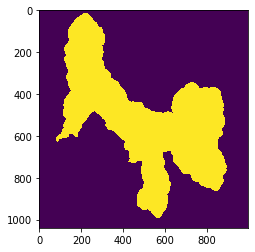

In [29]:
plt.imshow(mask)

In [30]:
#make row,col vectors of where to insert nodata values

size = 1000 # number of no data values to insert

idCol,idRow = np.where(mask == 1) # get locations of all points within the watershed

cols = np.random.choice(idCol,size = size,replace = False)
rows = np.random.choice(idRow, size = size, replace = False)

In [31]:
PupstreamNoData = os.path.join(testFolder,'PupNoData.tif') # output file name

# open source
with rs.open(Pupstream) as src:
    meta = src.meta
    noData = src.nodata
    P = src.read(1)

P[cols,rows] = noData # insert nodata values

# write out updated P grid
with rs.open(PupstreamNoData,'w',**meta) as dst:
    dst.write(P,1)

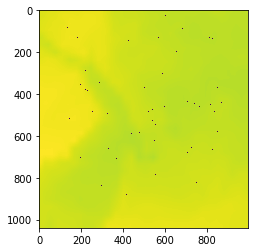

In [32]:
plt.imshow(P)

In [33]:
# accumualte the P raster with no data values added and produce the noData grids

accumRast = os.path.join(testFolder,'PupNoData_accum.tif')
outNoDataAccum = os.path.join(testFolder,'PupNoData_accumNoData.tif')
outNoData = os.path.join(testFolder,'PupNodataRast.tif')
outNoDataZero = os.path.join(testFolder,'PupNoDataZero.tif')

fc.accumulateParam(PupstreamNoData, upstreamFDRTau, accumRast,
                   outNoDataRast = outNoData, outNoDataAccum=outNoDataAccum,
                   zeroNoDataRast = outNoDataZero ,cores = 4)

Parameter Zero No Data raster written to: ./test_output/PupNoDataZero.tif
Parameter No Data raster written to: ./test_output/PupNodataRast.tif
Accumulating No Data Values
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/PupNoData_accumNoData.tif -wg ./test_output/PupNodataRast.tif -nc
Parameter no data accumulation written to: ./test_output/PupNodataRast.tif
Accumulating Data...
mpiexec -n 4 aread8 -p ./test_output/upstreamFDRtau.tif -ad8 ./test_output/PupNoData_accum.tif -wg ./test_output/PupNoDataZero.tif -nc


In [34]:
# make a FCPG accounting for noData
outRast = os.path.join(testFolder,'Pup_FCPG_noData.tif')

fc.make_fcpg(accumRast,upstreamFAC, outRast, noDataRast=outNoDataAccum)

Reading accumulated parameter file 2020-06-22 16:27:48.911860
Reading basin flow accumulation file 2020-06-22 16:27:48.946002
Correcting CPG for no data values
Computing CPG values 2020-06-22 16:27:48.990110
Replacing numpy nan values 2020-06-22 16:27:48.995036
Saving CPG raster 2020-06-22 16:27:48.995920
CPG file written to: ./test_output/Pup_FCPG_noData.tif


## Decay FCPG

Produce a FCPG where values are decayed based on their distance to a stream, this can be useful for producing FCPGs with more localized values rather than basin-average values.

In [35]:
upstreamFDRTauDinf = os.path.join(testFolder,'upstreamFDRDinf.tif') # D-infinity flow direction raster
fc.d8todinfinity(upstreamFDRTau,upstreamFDRTauDinf) # convert D8 flow directions to D-inf flow directions

Reclassifying Flow Directions...
TauDEM drainage direction written to: ./test_output/upstreamFDRDinf.tif


In [36]:
streamRast = os.path.join(testFolder,'upstreamDist2Stream.tif') # distance to stream raster
fc.dist2stream(upstreamFDRTau, upstreamFAC,900,streamRast,cores=4) # compute distance to streams

mpiexec -n 4 d8hdisttostrm -p ./test_output/upstreamFDRtau.tif -src ./test_output/upstreamFAC.tif -dist ./test_output/upstreamDist2Stream.tif, -thresh 900
Distance raster written to: ./test_output/upstreamDist2Stream.tif


In [37]:
decayRast = os.path.join(testFolder,'upstreamDecay.tif')
k = 0.5 # decay coefficient
fc.makeDecayGrid(streamRast,k,decayRast)

Building decay grid 2020-06-22 17:01:57.357537
Saving decay raster 2020-06-22 17:01:57.374526
Decay raster written to: ./test_output/upstreamDecay.tif


In [38]:
decayFAC = os.path.join(testFolder,'decayAccum.tif') # decay accumulation grid
decayParam = os.path.join(testFolder,'decayP.tif') # decay parameter accumulation grid
fc.decayAccum(upstreamFDRTauDinf,decayRast,decayFAC,cores=4) # perform the decay accumulation
fc.decayAccum(upstreamFDRTauDinf, decayRast, decayParam, # perform the parameter decay accumulation
              paramRast = Pupstream, cores = 4)

Accumulating parameter
mpiexec -n 4 dinfdecayaccum -ang ./test_output/upstreamFDRDinf.tif -dm ./test_output/upstreamDecay.tif -dsca ./test_output/decayAccum.tif, -nc
Parameter accumulation written to: ./test_output/decayAccum.tif
Accumulating parameter
mpiexec -n 4 dinfdecayaccum -ang ./test_output/upstreamFDRDinf.tif -dm ./test_output/upstreamDecay.tif -dsca ./test_output/decayP.tif, -wg ./test_output/Pup.tif -nc
Parameter accumulation written to: ./test_output/decayP.tif


In [39]:
decayFCPG = os.path.join(testFolder,'decayFCPG.tif')
fc.make_fcpg(decayParam,decayFAC,decayFCPG)

Reading accumulated parameter file 2020-06-22 17:09:52.215723
Reading basin flow accumulation file 2020-06-22 17:09:52.263398
Computing CPG values 2020-06-22 17:09:52.286236
Replacing numpy nan values 2020-06-22 17:09:52.295159
Saving CPG raster 2020-06-22 17:09:52.295884
CPG file written to: ./test_output/decayFCPG.tif


/mnt/c/Users/tbarnhart/projects/FCPGtools/FCPGtools/tools.py:354: RuntimeWarning: invalid value encountered in true_divide
  dataCPG = data / (corrAccum + 1) # make data CPG


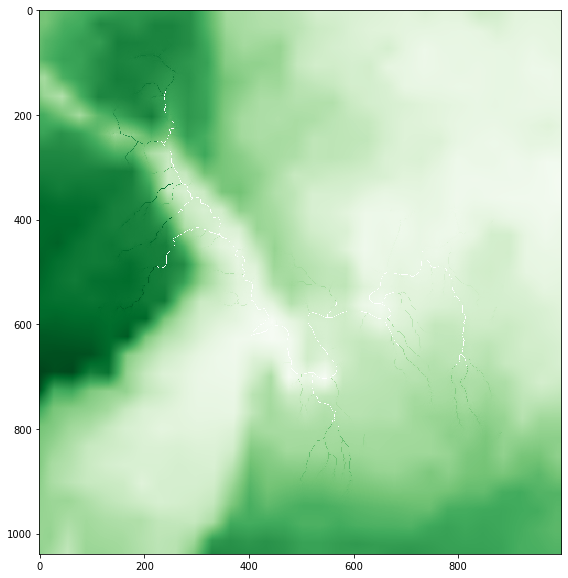

In [43]:
plot(decayFCPG, cmap = 'Greens')